## Aprendizado de Máquina Supervisionado - Exemplo 02
# _Text Classification_

Técnica de _machine learning_ que atribui um conjunto de categorias pré-definidas a um texto aberto.

Esse exemplo utiliza a biblioteca Python **Scikit-learn** (http://scikit-learn.org/).

**Scikit-learn** é uma biblioteca _open-source_ de _machine learning_ para Python que oferece uma variedade de algoritimos de regressão, classificação e _clustering_.

## Objetivo:
* Marcar automaticamente mensagens como _phishing_ por meio de seu conteúdo.

### Dados de entrada:

**Origem:**
* emails-enron-features.csv: E-mails comuns, sem _phishing_, obtidos do Enron Corpus;
* emails-phishing-features.csv: E-mails de _phishing_.

<i>Ambos os arquivos foram criados com base em um _fork_ do projeto: https://github.com/diegoocampoh/MachineLearningPhishing</i>

**Features description:**
* ID: (numerical) E-mail ID extraído do arquivo mbox;
* Content Type: (object) [Content type](https://en.wikipedia.org/wiki/MIME) do e-mail;
* Message: (object) Conteúdo do e-mail;

**Label**
* Phishy: (boolean) True se o e-mail for considerado _phishing_.

## Sumário:

1. [Import e Load](#p1)
2. [Exploração de Dados](#p2)
3. [Prepare the Data Set](#p3)
4. [Treinamento e Teste](#p4)
5. [Exercício](#p5)

<a id="p1"></a>
## 1. Import e Load

O data set é uma concatenção de dois arquivos [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) criados com base no [Enron e-mail corpus](https://www.cs.cmu.edu/~enron/) e uma [coletânea de e-mails de phishing](http://monkey.org/%7Ejose/wiki/doku.php?id=PhishingCorpus).

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [5]:
# For Google Colab (upload files first)
df = pd.concat(map(pd.read_csv, 
                   ['/content/emails-enron.csv', 
                    '/content/emails-phishing.csv']))


In [4]:
# For docker
#df = pd.concat(map(pd.read_csv, 
#                   ['data/emails-enron.csv', 
#                    'data/emails-phishing.csv']))

In [6]:
df.head()

,ID,Content Type,Message,Phishy
0,1,text/plain,?\tPay well ? and pay for performance (with bo...,False
1,2,text/plain,Trading Profits\r\n\r\nP. Allen\t\t200\r\nM. G...,False
2,3,text/plain,"John, as requested, please see the attached. I...",False
3,4,text/plain,Trading Profits\r\n\r\nP. Allen 200\r\nM. Gri...,False
4,5,text/plain,? Pay well =01( and pay for performance (with ...,False


<a id="p2"></a>
## 2. Exploração de Dados

Etapa inicial da análise de dados, em que exploramos os dados de uma forma não estruturada a fim de descobrir padrões iniciais, características e pontos de interesse.

In [7]:
type(df)

pandas.core.frame.DataFrame

In [8]:
df.shape

(4000, 4)

### Verificar valores nulos

Valores nulos nos dados podem reduzir o poder estatístico de um estudo produzindo estimativas tendenciosas e levando a conclusões inválidas ([Why are missing values a problem?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/)).

In [9]:
df.isnull().sum()

ID              0
Content Type    0
Message         0
Phishy          0
dtype: int64

### Verificar a coluna com os dados "de sáida", rótulo *Phishy*

In [ ]:
df['Phishy'].unique()

In [11]:
df['Phishy'].value_counts()

False    2000
True     2000
Name: Phishy, dtype: int64

Podemos observar que nesse caso específico temos um [data set balanceado](https://medium.com/analytics-vidhya/what-is-balance-and-imbalance-dataset-89e8d7f46bc5): 2000/4000 e-mails (50%) são rotulados como _Phishy_.

Isso significa que o modelo de _machine learning_ que iremos criar precisa ter um desempenho **melhor que 50%** para ser melhor do que uma escolha aleatório.

### Verificar os tipos das colunas de _features_

In [12]:
df.dtypes

ID               int64
Content Type    object
Message         object
Phishy            bool
dtype: object

### "Saco de Palavras" (_Bag of Words_) e TF-IDF

Uma **Bag of Words** é uma representação simplificada utilizada em Processamento Natural de Linguagem (_Natural Language Processing - NLP_), em que um texto (uma frase ou um documento) é representado como um "saco" (conjunto) de suas palavras, desconsiderando qualquer análise gramatical ou ordem das palavras, porém mantendo a multiplicidade.



**Exemplo:**

In [13]:
# Frases
s1 = "Em um buraco no chão vivia um Hobbit"
s2 = "Não é sensato deixar um dragão fora dos teus cálculos se vives perto dele"

In [15]:
# Vocabulary
vocab = {}
i = 1

for word in s1.lower().split()+s2.lower().split():
    if word in vocab:
        continue
    else:
        vocab[word]=i
        i+=1
        
print(vocab)

{'em': 1, 'um': 2, 'buraco': 3, 'no': 4, 'chão': 5, 'vivia': 6, 'hobbit': 7, 'não': 8, 'é': 9, 'sensato': 10, 'deixar': 11, 'dragão': 12, 'fora': 13, 'dos': 14, 'teus': 15, 'cálculos': 16, 'se': 17, 'vives': 18, 'perto': 19, 'dele': 20}


In [16]:
# Empty vectors with an index for each word in the vocabulary
s1_vector = ['s1']+[0]*len(vocab)

# Map the frequencies of each word to the vectors
for word in s1.lower().split():
    s1_vector[vocab[word]]+=1
    
print(s1_vector)

['s1', 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Empty vectors with an index for each word in the vocabulary
s2_vector = ['s2']+[0]*len(vocab)

# Map the frequencies of each word to the vectors
for word in s2.lower().split():
    s2_vector[vocab[word]]+=1
    
print(s2_vector)

In [18]:
# Vectors comparison
print(f'{s1_vector}\n{s2_vector}')

['s1', 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['s2', 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


No exemplo acima, cada vetor pode ser considerado uma **bag of words**. Estendendo essa lógica para milhares de entradas, podemos perceber que o dicionário de vocabulário poderia crescer para centenas de milhares de palavras.

Na prática, o modelo **bag of words** é usado principalmente como uma ferramenta de geração de _features_. Depois de transformar o texto em uma **bag of words**, é possível calcular várias métricas para caracterizar o texto. O tipo mais comum de métrica, ou _feature_, calculada a partir desse modelo é a frequência de termos, ou seja,  número de vezes ue um termo aparece no texto.

### TF-IDF

**TF-IDF**, abreviação de 'Term Frequency–Inverse Document Frequency', é uma estatística numérica destinada a refletir a importância de uma palavra para um documento.

Considera basicamente frequências de termos (quantidade de ocorrências do termo / quantidade de termos na frase) e frequência inversa de frases (quantidade total de frases / quantidade de frases que contém o termo), o que diminui o peso dos termos que ocorrem com muita frequência no documento e aumenta o peso de termos que ocorrem raramente.

### Outras definições interessantes

* **Stop words**: palavras irrelevantes, termos frequentes que podem ser ignorados no vocabulário (exe: 'a', 'isso', 'e', ...)
* **Tokenization**: divisão de documentos em termos individuais (frequentemente utiliaz conceitos de morfologia)
* **Word stems**: uso da raiz de uma palavrá (exe: ao invés do vocabulário conter ambas as palavras 'dragão' e 'dragões', poderia incluir somente 'dragão')
* **Tagging**: adiciona mais dimensões aos _tokens_ (parte do discursos, dependências gramaticais, etc.)

<a id="p3"></a>
## 3. Preparando o Data Set

### Definir colunas de _features_ e de rótulos

Colunas de **feature** são aquelas utiliadas para prever as colunas de **label** (rótulo). Dessa vez vamos utilizar o próprio texto como feature.

Por **convenção**, _features_ são representadas como **X** (uppercase) e labels como **y** (lowercase).

In [19]:
from sklearn.model_selection import train_test_split

X = df['Message']
y = df['Phishy']

### Dividir os dados em conjuntos de treinamento e teste

Aqui nos vamos atribuir 70% dos dados para a fase de treinamento e 30% para a fase de teste.

Vamos utilizadr a variável de configuração `random_state` (semente de distribuição) para garantir a replicabilidade dos resultados.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train.shape

(2800,)

### CountVectorizer

Pré-processamento de texto, tokenização e a capacidade de filtrar _stopwords_ são funcionalidades já inclusas no módulo [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), que permite a construção de um dicionário de _features_ e transforma documentos em vetores dessas _features_, semelhante a um **bag of words**.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

X_train_cv = count_vect.fit_transform(X_train)
X_train_cv.shape

(2800, 82671)

Após utiliar o `CountVectorizer`, nosso conjunto de dados de treinamento agora possui 2800 e-mails com <font color=green>**82671**</font> _features_.

In [22]:
# Extracted features
count_vect.get_feature_names_out()

array(['00', '000', '0000', ..., 'ёп2007', 'ёпregions', 'ўз'],
      dtype=object)

### Tfidf Transformer

TF-IDF pode ser calculada utilizando o módulo do Scikit-learn's [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_cv)
X_train_tfidf.shape

(2800, 82671)

O método `fit_transform()` executa duas operations nesse caso: ajusta um estimador para os dados e transforma nossa matrix de palavras em (X_train_cv) uma representação tf-idf.

### TfidfVectorizer

O módulo [TfidVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) combina os módulos `CountVectorizer` e `TfidTransformer` em um só.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf.shape

(2800, 82671)

<a id="p4"></a>
## 4. Treinamento e Teste

Como nosso conjunto de treinamento precisa ser vetoriazdo antes de ser processado pelo classificador, podemos usar um [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), uma classe que funciona como um classificador composto.

Nesse exemplo, vamos utilizar um algoritimo de [Linear Support Vector Classification](https://scikit-learn.org/stable/modules/svm.html) devido a seu bom desempenho com entradas esparsas: ([LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)).

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Pipeline
lsvc = Pipeline([
                  ('tfidf', TfidfVectorizer()),
                  ('clf', LinearSVC()),
                 ])

# Train
lsvc = lsvc.fit(X_train, y_train)  

In [28]:
# Create a prediction set
predictions = lsvc.predict(X_test)

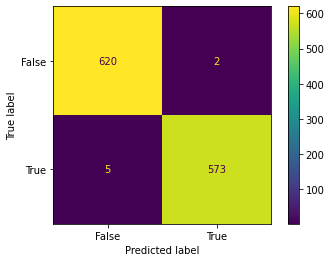

In [29]:
# Print a confusion matrix
cm = metrics.confusion_matrix(y_test, predictions, labels=lsvc.classes_)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lsvc.classes_)
disp.plot()

In [30]:
# Classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99       622
        True       1.00      0.99      0.99       578

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



In [31]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.9941666666666666


<a id="p5"></a>
## 5. Exercício

### 5.1. Teste novos dados com o modelo treinado para verificar a predição 

In [32]:
test_email = "Dear user, \
Your e-mail quota is running out. \
Please follow the link below to fix the issue: \
http://www.mailquota.com?/exec/fix\
and update your account information."

In [33]:
print(lsvc.predict([test_email]))

[ True]


### 5.2. Melhore o modelo utilizando `stop_words`

In [34]:
stop_words = ...

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Pipeline
lsvc = Pipeline([
                  ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                  ('clf', LinearSVC()),
                 ])

# Train
...

Ellipsis

In [ ]:
# Create a prediction set
...

In [ ]:
# Print a confusion matrix
...

In [ ]:
# Classification report
...

In [ ]:
# Print the overall accuracy
...